In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
import pandas as pd
import numpy as np
import json

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import dask.bag as db

def dask_zip_reader(
  archive_folder: str='/content/drive/MyDrive/CUP_IT/VK_cup_dataset.zip', 
  test_file: str='ranking_test.jsonl', train_file: str='ranking_train.jsonl'
): 
  test_data = db.read_text(
      f'zip://{test_file}',
      storage_options={'fo': archive_folder},
      encoding='Windows-1251'
  ).map(json.loads)

  train_data = db.read_text(
      f'zip://{train_file}',
      storage_options={'fo': archive_folder},
      encoding='Windows-1251'
  ).map(json.loads)

  test_df = test_data.to_dataframe().compute()
  train_df = train_data.to_dataframe().compute()

  return test_df, train_df

test, train = dask_zip_reader()

In [8]:
train = train.explode(column='comments')
train['comment'] = train.comments.map(lambda dic: dic['text'])
train['score'] = train.comments.map(lambda dic: dic['score'])
train.drop(labels=['comments'], axis=1, inplace=True)
train['full_text'] = train.text + ' |||| ' + train.comment
train.head()

,text,comment,score,full_text
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,How many summer Y Combinator fundees decided n...
0,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1,How many summer Y Combinator fundees decided n...
0,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2,How many summer Y Combinator fundees decided n...
0,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3,How many summer Y Combinator fundees decided n...
0,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4,How many summer Y Combinator fundees decided n...


In [10]:
lemmatized_comments = pd.read_csv('/content/drive/MyDrive/CUP_IT/comments_lemmatized.csv')
lemmatized_posts = pd.read_csv('/content/drive/MyDrive/CUP_IT/posts_lemmatized.csv')

lemmatized_posts['text'] = lemmatized_posts['text'].str.replace("'",'') \
.str.rstrip(']').str.lstrip('[').str.replace(' ','').str.split(',')

lemmatized_comments['comment'] = lemmatized_comments['comment'] \
.str.replace("'",'').str.rstrip(']').str.lstrip('[').str.replace(' ','') \
.str.split(',')

EDA
---

In [12]:
# необходимые для EDA библиотеки
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
from matplotlib.patches import Rectangle

# техническая функция красивой обертки текста
def wrap_text(text: str):
  return textwrap.fill(text, replace_whitespace=False, fix_sentence_endings=True)

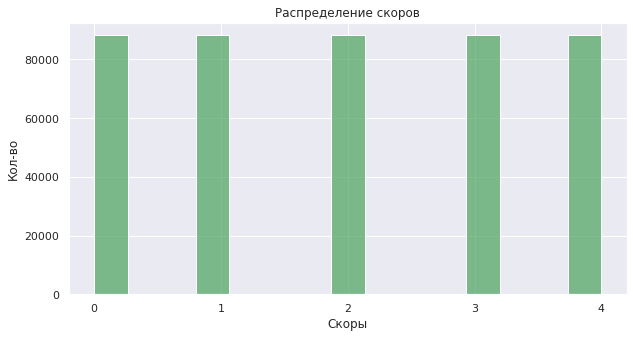

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_title('Распределение скоров')
ax.set_xticks(train.score.unique(), minor=False)
ax.set_xlabel('Скоры')
ax.set_ylabel('Кол-во')
sns.set(style="darkgrid")
sns.histplot(train.score, color='g', bins=15)
None

In [ ]:
def lda_decompose(text_column: pd.Series = None, n_topics: int = 6):

  """ 
    Функция, в рамках которой происходит кластеризация тем с помощью LDA

    text_column: pd.Series
      - Столбец с текстовыми данными
    n_topics: int
      - Количество тем для разложения

    :returns: 
      model: sklearn.decomposition.LatentDirichletAllocation
        - сформированная модель разложения LDA
      Z: np.array
        - матрица Z распределения тем внутри документов
      feature_names: np.array
        - список из слов, созданный специально для индексации
      topics: np.array
        - массив из сгенерированных тем
  """

  vectorizer = CountVectorizer(
    stop_words=list(set(stopwords.words('english')))
  )
  X = vectorizer.fit_transform(text_column)
  lda = LDA(
    n_components=n_topics,
    random_state=42
  )
  lda.fit(X)

  # Возвращаем LDA модель, матрицу Z, список слов и темы
  return lda, lda.transform(X), \
    vectorizer.get_feature_names_out(), np.arange(n_topics) + 1 

In [ ]:
def top_words_by_topics(components, feature_names, n_top_words=20):
  """
    Генерация распределения частот самых популярных слов по темам

    components: np.array
      - Распределение слов по столбцам-псевдотемам
    feature_names: np.array
      - массив тем
    n_top_words: int
      - количество самых популярных слов для рассмотрения. Чем больше
      - тем (однако не всегда) проще интерпретировать тему
  """
  fig, axs = plt.subplots(2, 3, figsize=(15, 12), sharex=True)
  feature_names = np.array(feature_names)
  axs = axs.flatten()

  # луп по темам
  for topic_index, topic in enumerate(components):
    top_features_indices = topic.argsort()[:-n_top_words-1:-1]
    top_features = feature_names[top_features_indices]
    weights = topic[top_features_indices]

    # непосредственное создание столбчатой диаграммы
    ax = axs[topic_index]
    ax.barh(top_features,weights,height=.6)
    ax.set_title(f'Тема публикации: {topic_index+1}')
    ax.invert_yaxis()
    ax.tick_params(axis='both',which='major',labelsize=15)
    for position in ['top', 'right', 'left']:
      ax.spines[position].set_visible(False)

  fig.suptitle('LDA-анализ слов', fontsize=30)
  return None

In [ ]:
def topic_distribution(
  posts_column: pd.Series, post_index: int, 
  Z: np.array, topics: np.array
):
  """ 
    Функция строит распределение вероятностей тем для конкретного поста 

    posts_column: pd.Series:
      - столбец изучаемых текстов (в нашем случае постов)
    post_index: int
      - iloc индекс конкретного текста
    Z: np.array
      - матрица Z, получившаяся в результате применения lda_decompose()
    topics: np.array
      - массив тем
  """
  fig, ax = plt.subplots()
  ax.barh(topics, Z[post_index])
  ax.set_yticks(topics)
  ax.set_title(f'Распределение тем для поста с индексом [{post_index}]')
  print(wrap_text(posts_column.iloc[post_index]))
  return None

In [ ]:
train[train['text'].str.contains('hn')]['text'].unique()

In [ ]:
lda, Z, feature_names, topics = lda_decompose(new_lemmatized_posts.str.join(' '))

In [ ]:
import h5py
with h5py.File('lda.h5', 'w') as h5file:
  h5file.create_dataset('components',data=lda.components_)
  h5file.create_dataset('features',data=feature_names)
  h5file.create_dataset('z',data=Z)
  h5file.create_dataset('topics',data=topics)

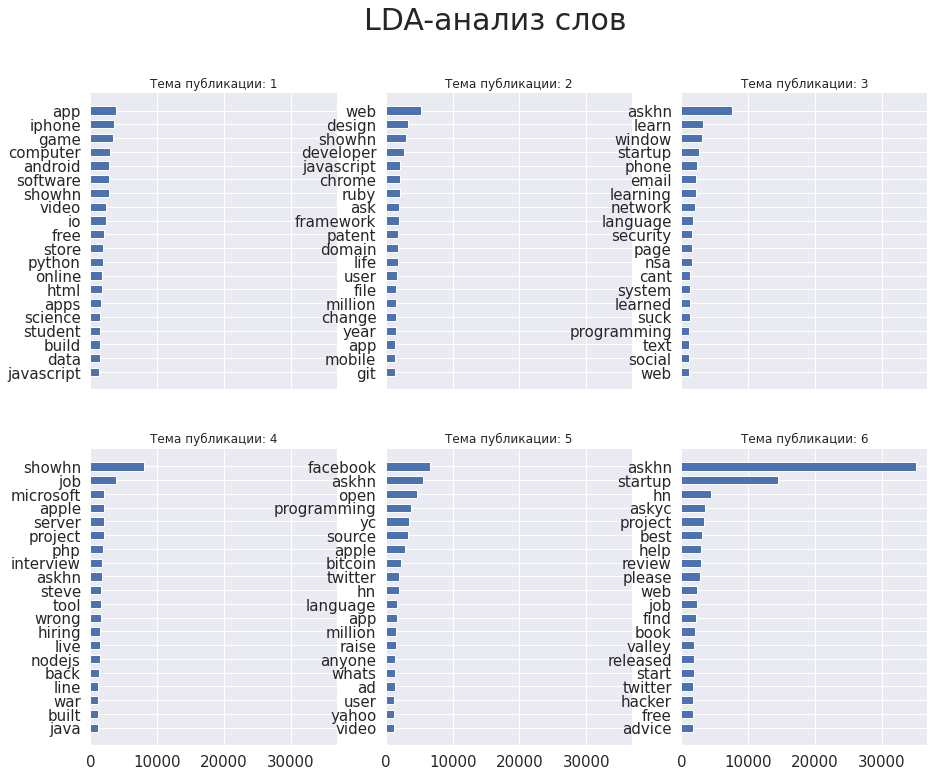

In [ ]:
h5fileTest = h5py.File('lda.h5', 'r')
top_words_by_topics(h5fileTest.get('components'),h5fileTest.get('features'))

fortune favor big turd screw money art


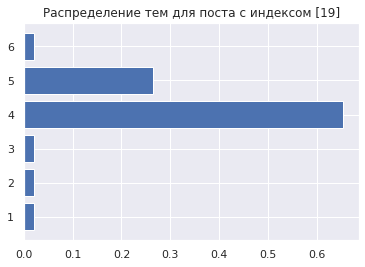

In [ ]:
topic_distribution(new_lemmatized_posts.str.join(' '), 19, Z, topics)

In [ ]:
import matplotlib.pylab as pylab
params = {
  'figure.figsize': (10, 10),
  'legend.fontsize': 'small',
  'axes.labelsize': 'xx-large',
  'axes.titlesize':'x-large',
  'xtick.labelsize':'x-small',
  'ytick.labelsize':'x-small'
}
pylab.rcParams.update(params)

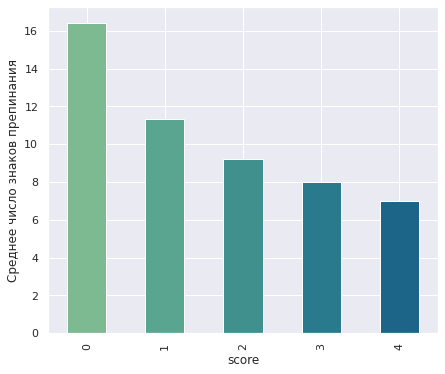

In [ ]:
def punctuation_stats(text_df: pd.DataFrame, comments_col: str):
  text_df['charcount'] = text_df[comments_col].str.count(r'[.,!?]')
  fig, ax = plt.subplots(figsize=(7,6))
  text_df.groupby('score')['charcount'].mean().plot.bar(
    ylabel='Среднее число знаков препинания',
    color=sns.color_palette("crest"), ax=ax
  )
  return None

punctuation_stats(train,'comment')

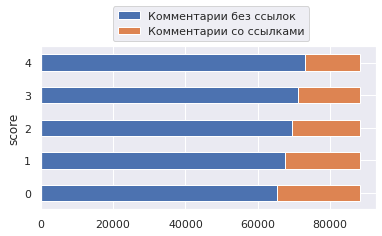

In [ ]:
def links_density(text_df: pd.DataFrame, comments_col: str):
  text_df['link_containment'] = text_df[comments_col].str.contains('http')
  contains_links = text_df.groupby('score')['link_containment'].sum()
  links_vs_all = pd.concat([
    text_df.groupby('score').size() - contains_links,
    contains_links
  ], axis=1)
  links_vs_all.columns = ['Комментарии без ссылок', 'Комментарии со ссылками']
  fig, ax = plt.subplots(figsize=(6,3))
  links_vs_all.plot.barh(
    stacked=True, ax=ax
  )
  ax.legend(bbox_to_anchor=(0.2, 1))
  
  return None

links_density(train,'comment')

<ipython-input-20-3c151a1463a3>:23: RuntimeWarning: invalid value encountered in true_divide
  simmatrix = comments_tfidf.multiply(posts_tfidf).sum(axis=1) / \


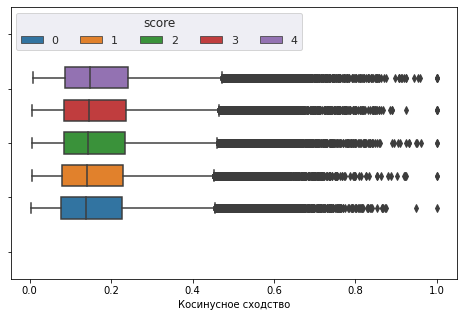

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy

def cossim_by_scores(posts: pd.Series, comments: pd.Series, original_df: pd.DataFrame):
  """
    Разброс значений синусного сходства между комментариями и постами
    в виде ящика с усами

    posts: pd.Series
      - Посты
    comments: pd.Series
      - Комментарии 
    original_df: pd.DataFrame
      - Оригинальный трейнинг-датафрейм
  """
  vectorizer = TfidfVectorizer(decode_error='ignore', analyzer='word')
  posts_tfidf = scipy.sparse.csr_matrix(vectorizer.fit_transform(posts))
  comments_tfidf = scipy.sparse.csr_matrix(vectorizer.transform(comments))

  # вычисление матрицы синусных сходств. Без использования SciPy возникала
  # ошибка нехватки RAM
  simmatrix = comments_tfidf.multiply(posts_tfidf).sum(axis=1) / \
  (scipy.sparse.linalg.norm(comments_tfidf,axis=1) * \
  scipy.sparse.linalg.norm(posts_tfidf,axis=1)).reshape(-1,1)

  print(simmatrix.shape)

  original_df['cosine'] = simmatrix
  original_df['score_str'] = original_df['score'].astype(str)
  fig, ax = plt.subplots(figsize=(8,5))
  sns.boxplot(
    data=original_df[original_df['cosine'] > 0], x="cosine", y='score_str', 
    hue='score_str', order=['4','3','2','1','0'], ax=ax, width=2
  )
  sns.set(style="darkgrid")
  ax.set(
    ylabel='', yticklabels=[], xlabel='Косинусное сходство'
  )
  ax.legend(title='score', loc='upper left', ncol = len(ax.lines))
  return None

cossim_by_scores(
  lemmatized_posts['text'].str.join(' '), 
  lemmatized_comments['comment'].str.join(' '), 
  train
)

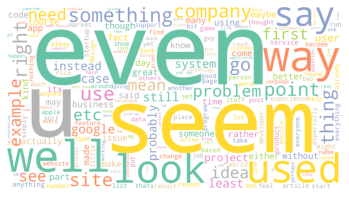

In [ ]:
def wordcloud_by_posts(posts: pd.Series):
  wordcloud = WordCloud(
    width=1980,height=1080,
    background_color='white', colormap='Set2'
  ).generate(
    ' '.join(posts.explode())
  )
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  return None

wordcloud_by_posts(lemmatized_comments['comment'])

Облако слов для комментариев со скором 4:


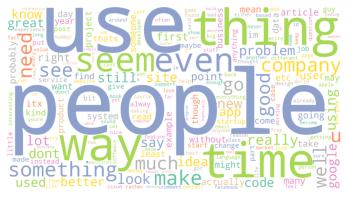

In [13]:
def build_wordcloud(text_series: pd.Series, scoring: int, initial_df: pd.DataFrame):
  """ 
    Эта функция создает облако слов в зависимости от их частоты 

    text_series: pd.Series
      - Серия из списков лемматизированных токенов
    scoring: int
      - Скор комментариев, по которому будет происходить фильтрация
    initial_df: pd.DataFrame
      - Трейнинг-датафрейм с изначальным датасетом и скорами
  """
  wordcloud = WordCloud(
      width=1980,height=1080,
      background_color='white', colormap='Set2'
    ).generate(
    ' '.join(text_series[
        initial_df['score'].astype(int) == scoring
    ].values.tolist())
  )
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  return None

copied_comments = lemmatized_comments.copy()
copied_comments.columns = ['lemma_comment']
lemmatized_series = copied_comments['lemma_comment'].str.join(' ')
lemmatized_series.index = train.index
for score in range(4,5):
  print(f'Облако слов для комментариев со скором {score}:')
  build_wordcloud(lemmatized_series, score, train)

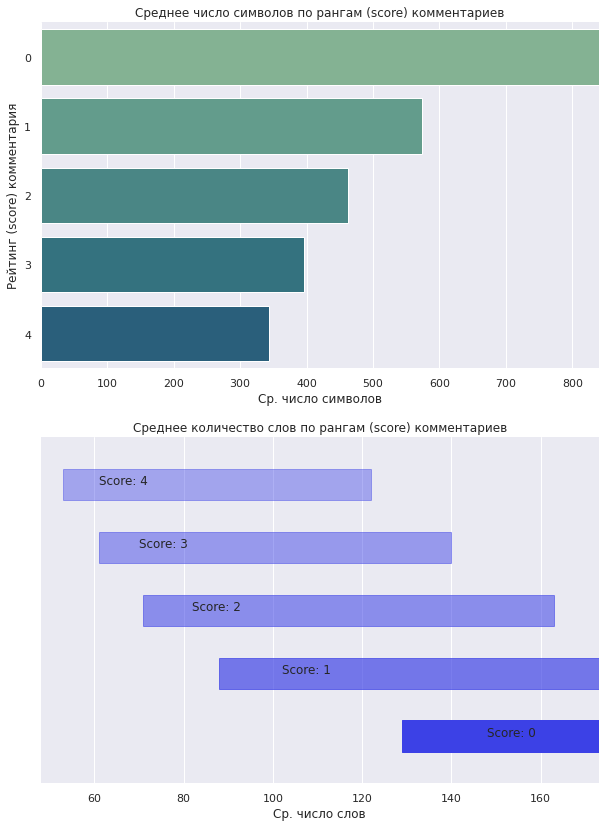

In [ ]:
def words_symbols_by_scores(text_df: pd.DataFrame, comments_col: str):
  """ 
    Эта функция создает горизонтальный бар-плот по среднему кол-ву символов,
    а также слов по комментариям относительно их рейтинга (скора)

    text_df: pd.DataFrame
      - Датафрейм с текстовыми комментариями
    comments_col: str
      - Название столбца с комментатриями
  """

  text_df['comments_len'] = text_df[comments_col].str.len()
  statistics = train.groupby('score')['comments_len'] \
  .mean().reset_index() \
  .sort_values('comments_len', ascending=False)

  # Статистика по среднему числу символов
  fig, axs = plt.subplots(2, 1, figsize=(10, 14))
  color_palette = sns.color_palette("crest")
  sns.set_palette(color_palette)
  sns.barplot(
    x="comments_len", y="score", data=statistics, 
    orient='h', ax=axs[0]
  )
  axs[0].set(
    xlim=(0, statistics['comments_len'][0]), 
    ylabel="Рейтинг (score) комментария", xlabel="Ср. число символов",
    title="Среднее число символов по рангам (score) комментариев"
  )

  # Статистика по среднему числу слов на основе символов
  statistics['low_word_bound'] = (statistics['comments_len'] / 6.5).round()
  statistics['high_word_bound'] = (statistics['comments_len'] / 5).round()
  min_max = statistics['low_word_bound'].max()
  for index, (low, high) in enumerate(zip(
    statistics['low_word_bound'],
    statistics['high_word_bound']
  )):
    word_count_mean = round((low+high)/2)
    alpha = low / min_max
    current_y_pos = index+0.5
    axs[1].add_patch(Rectangle((low, current_y_pos), high, 0.5, alpha=alpha, color='#3c41e6'))
    axs[1].text(word_count_mean, current_y_pos+0.25, f'Score: {index}')
  axs[1].set(
    xlim=(
      statistics['low_word_bound'].min()-5, 
      statistics['high_word_bound'].max()+5
    ), 
    ylim=(
      0, 5.5
    ),
    yticks=[],
    ylabel="", xlabel="Ср. число слов",
    title="Среднее количество слов по рангам (score) комментариев"
  )
  sns.despine(left=True, bottom=True)

  return None

words_symbols_by_scores(train,'comment')

On average, text contains between 5 and 6.5 characters per word including spaces and punctuation.
For example:
* The Great Gatsby averages 5.44 characters per word.
* Harry Potter and the Sorcerer's Stone averages 5.55 characters per word.
* A typical New York Times article averages 6.05 characters per word.

In [ ]:
train = train.reset_index()[['text', 'comment', 'score']]
train

In [ ]:
lemmatized_comments.index = train.index
lemmas_and_scores = pd.concat(
  [
    lemmatized_comments['comment'].explode(), train['score']
  ], 
  axis=1
)

In [ ]:
# cleaned comments tests
new_lemmatized_comments.index = train.index
lemmas_and_scores_cleaned = pd.concat(
  [
    new_lemmatized_comments.explode(), train['score']
  ], 
  axis=1
)

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import nltk

def words_by_scores(lemmas: pd.DataFrame, count_array: pd.Series, words_count: int = 10, most_popular: bool = True):
  """ 
    Статистика по словам относительно рейтинга (score) комментариев

    lemmas: pd.DataFrame
      - Датафрейм с сформированными леммами относительно скоров
    count_array: pd.Series
      - Границы по числу употреблений слова (чтобы избавиться от стоп-слов) 
    words_count: str
      - Количество популярных слов
    most_popular: bool
      - Вывести самые популярные / непопулярные слова
  """

  fig, axs = plt.subplots(3,2,figsize=(9,9))
  for score in range(5):
    most_common_words = nltk.FreqDist(
      lemmas[lemmas['score'] == score]['comment']
    ).most_common()

    # сбор самых популярных/не популярных слов
    most_common_words = list(
      filter(lambda wordf: wordf[1] < count_array[score], most_common_words)
    )[:words_count] if most_popular else list(
      filter(lambda wordf: wordf[1] < count_array[score]*.01, most_common_words)
    )[:words_count]
    print(f'Скор: {score}. Слова: {most_common_words}')

    words_df = pd.DataFrame(most_common_words, columns=['слово','частота'])
    shape_ = words_df.shape[0]
    palette =  [(x/(shape_*1.5), x/(shape_*1.2), 0.8) for x in range(shape_)]
    x_pos = 0 if score % 2 == 0 else 1
    y_pos = 0 if score in [0, 1] else 1 if score in [2, 3] else 2
    words_df.plot.bar(
      y='частота', x='слово', color=palette, 
      ax=axs[y_pos][x_pos], title=f'score={score}'
    )
  fig.tight_layout()

  return None

count_arr = lemmas_and_scores_cleaned.groupby('score')['comment'].size()*.0004
words_by_scores(lemmas_and_scores_cleaned, count_arr, words_count=30)

In [ ]:
from nltk.util import ngrams

def ngrams_by_scores(lemmas: pd.DataFrame, ngram_count: int = 10, ngram_level: int = 2):
  """ 
    Статистика по нграммам относительно рейтинга (score) комментариев

    lemmas: pd.DataFrame
      - Датафрейм с комментариями
    comments_col: str
      - Столбец с комментариями
    ngram_count: int
      - Количество популярных биграмм
    ngram_level: int
      - Количество нграмм 
  """

  # построение распределения слов относительно скоров
  fig, axs = plt.subplots(3,2,figsize=(9,9))
  for score in range(5):
    most_common_nrams = nltk.FreqDist(
      [
          f'{el[0]} {el[1]}' if ngram_level == 2 
          else f'{el[0]} {el[1]} {el[2]}'
          for el in ngrams(
            lemmas[lemmas['score'] == score]['comment'], 
            ngram_level
          )
      ]
    ).most_common()
    most_common_nrams = list(filter(
      lambda ngram_: ngram_[1] <= 500, most_common_nrams
    ))[:ngram_count]
    print(f'Скор: {score}. Нграммы: {most_common_nrams}')
    words_df = pd.DataFrame(most_common_nrams, columns=['нграмма','частота'])
    palette =  [(x/(ngram_count), x/(ngram_count+2), 0.8) for x in range(words_df.shape[0])]
    x_pos = 0 if score % 2 == 0 else 1
    y_pos = 0 if score in [0, 1] else 1 if score in [2, 3] else 2
    words_df.plot.bar(
      y='частота', x='нграмма', color=palette, 
      ax=axs[y_pos][x_pos], title=f'score={score}'
    )
  fig.tight_layout()

  return None

Скор: 0. Нграммы: [('good news', 150), ('dont seem', 150), ('two people', 150), ('people around', 150), ('able find', 150), ('thats good', 150), ('really understand', 150), ('paul graham', 149), ('there reason', 149), ('glad see', 149), ('user base', 149), ('take year', 149), ('kind like', 149), ('youre probably', 149), ('web design', 149), ('wont get', 149), ('pretty easy', 149), ('time dont', 149), ('article make', 149), ('two month', 148)]
Скор: 1. Нграммы: [('many many', 150), ('like great', 150), ('whole lot', 150), ('might also', 150), ('may want', 150), ('article like', 150), ('battery life', 150), ('tool like', 150), ('even worse', 149), ('never seen', 149), ('get right', 149), ('press release', 149), ('going back', 149), ('want something', 149), ('hard drive', 149), ('still need', 149), ('get much', 149), ('ixm going', 149), ('day week', 148), ('take long', 148)]
Скор: 2. Нграммы: [('would rather', 150), ('ask question', 150), ('people donxt', 150), ('find interesting', 149), 

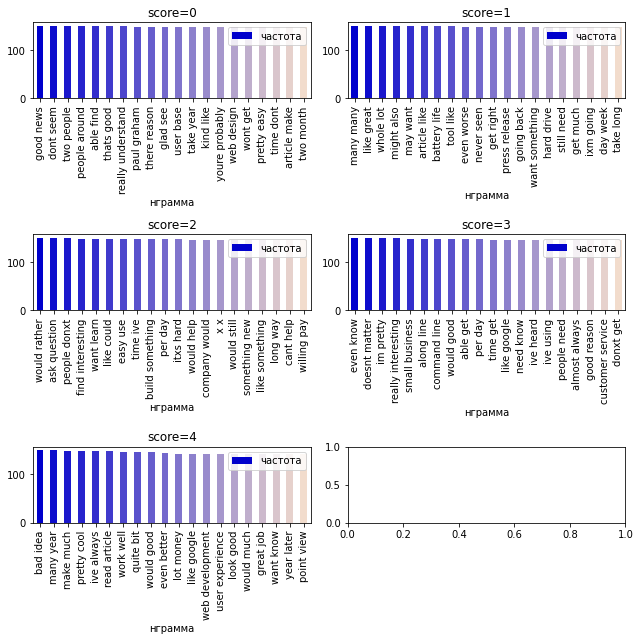

In [ ]:
ngrams_by_scores(lemmas_and_scores, ngram_count=20)

Скор: 0. Нграммы: [('open source project', 279), ('im pretty sure', 178), ('couple year ago', 142), ('x x x', 134), ('open source software', 133), ('mac o x', 131), ('id like see', 128), ('go long way', 121), ('long time ago', 120), ('spend lot time', 118)]
Скор: 1. Нграммы: [('open source project', 237), ('im pretty sure', 137), ('would love see', 115), ('id like see', 108), ('couple year ago', 103), ('would like see', 101), ('long time ago', 92), ('mac o x', 89), ('open source software', 86), ('spend lot time', 84)]
Скор: 2. Нграммы: [('open source project', 157), ('im pretty sure', 123), ('id like see', 111), ('would love see', 97), ('id love see', 93), ('would like see', 88), ('mac o x', 87), ('long time ago', 85), ('seems like would', 76), ('couple year ago', 76)]
Скор: 3. Нграммы: [('open source project', 151), ('would love see', 119), ('im pretty sure', 98), ('id like see', 90), ('would like see', 86), ('couple year ago', 76), ('long time ago', 75), ('mac o x', 66), ('seems like

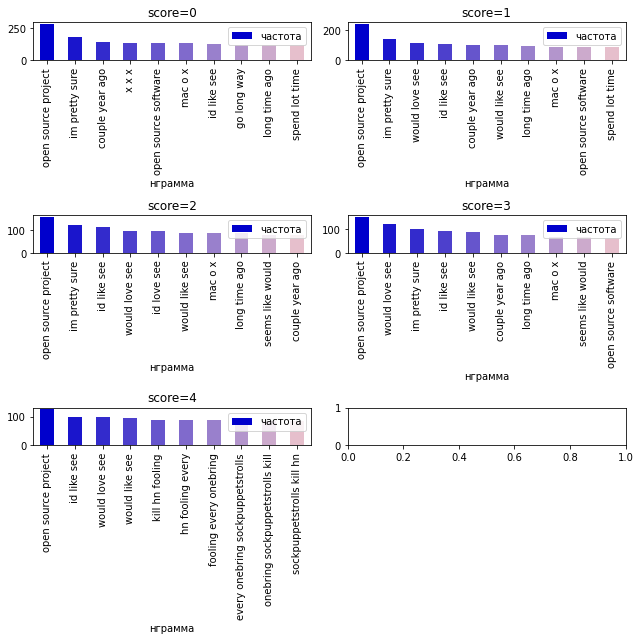

In [ ]:
ngrams_by_scores(lemmas_and_scores, ngram_level=3)